<a href="https://colab.research.google.com/github/TailUFPB/fundos-imobiliarios/blob/main/Pre_Processamento_FIIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Pré-processamento dos dados**

Para utilizarmos os dados de fundos imobiliários no nosso modelo e na EDA, é necessário primeiro fazer um processamento inicial neles, tornando-os aptos para serem analisados e colocados no nosso modelo:

## Importando os dados

In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

In [2]:
#Recebendo o CSV dos fundos

url = 'https://raw.githubusercontent.com/TailUFPB/fundos-imobiliarios/main/CSV_inicial.csv'
data = pd.read_csv(url)
df_fiis = pd.DataFrame(data)
#Retirando colunas com dados redundantes ou com uma quantidade muito grande de dados faltantes
df_fiis.drop(['Unnamed: 0', 'DY (3M)Acumulado', 'DY (6M)Acumulado', 'DY (12M)Acumulado','DYPatrimonial', 'VariaçãoPatrimonial', 'Rentab. Patr.Acumulada', 'Rentab. Patr.no Período', 'VacânciaFinanceira'], axis='columns', inplace=True)

Estado inicial dos dados:

In [3]:
df_fiis

,Códigodo fundo,Setor,Preço Atual,Liquidez Diária,Dividendo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,DY Ano,Variação Preço,Rentab.Período,Rentab.Acumulada,PatrimônioLíq.,VPA,P/VPA,VacânciaFísica,QuantidadeAtivos
0,ABCP11,Shoppings,"R$ 70,84",959.0,"R$ 0,05","0,06%","0,43%","0,45%","0,33%","1,30%","1,82%","1,88%","1,90%","R$ 1.078.043.159,45","R$ 88,34",80.0,"9,10%",1
1,AFCR11,Híbrido,"R$ 110,30",1536.0,"R$ 1,08","0,96%","0,94%","0,90%","0,00%","4,54%","-3,03%","-2,10%","1,90%","R$ 123.444.882,79","R$ 103,97",106.0,NaN,0
2,AFOF11,Títulos e Val. Mob.,"R$ 140,00",61.0,"R$ 8,76","8,76%","2,92%","1,46%","1,40%","16,82%","0,00%","8,76%","17,52%","R$ 39.463.995,21","R$ 107,50",130.0,NaN,0
3,AIEC11,Lajes Corporativas,"R$ 86,27",16775.0,"R$ 0,57","0,65%","0,64%","0,62%","0,00%","3,12%","-3,30%","-2,67%","-2,90%","R$ 483.603.291,35","R$ 100,23",86.0,"0,00%",2
4,ALMI11,Lajes Corporativas,"R$ 1.160,00",54.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","2,27%","2,27%","-28,29%","R$ 229.423.903,28","R$ 2.063,59",56.0,"68,15%",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,XPML11,Shoppings,"R$ 107,49",46412.0,"R$ 0,30","0,29%","0,22%","0,33%","0,29%","0,98%","-4,01%","-3,73%","-6,84%","R$ 2.001.282.055,70","R$ 109,91",98.0,"5,50%",13
234,XPPR11,Outros,"R$ 62,80",32335.0,"R$ 0,48","0,75%","0,72%","0,69%","0,76%","3,44%","-5,19%","-4,47%","-17,84%","R$ 638.005.453,29","R$ 87,20",72.0,"39,00%",4
235,XPSF11,Outros,"R$ 97,50",20482.0,"R$ 0,87","0,89%","0,82%","0,79%","0,78%","4,01%","0,56%","1,45%","6,23%","R$ 425.281.193,51","R$ 98,21",99.0,NaN,0
236,XTED11,Lajes Corporativas,"R$ 7,13",6961.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%","1,10%","1,10%","-37,83%","R$ 25.472.636,57","R$ 14,21",50.0,"0,00%",1


## Transformando strings em valores númericos

A primeira etapa do pré-processamento que vamos fazer é transformar os dados que estão como string para float (Ex: R$ 0,48 para 0.48):

In [4]:
for column in df_fiis.columns:
  new_column = []
  for i in range(len(df_fiis)):
    if df_fiis[column].iloc[i] != np.NaN:
      if type(df_fiis[column].iloc[i]) == str and df_fiis[column].iloc[i][-1] == "%":
        new_column.append(float(".".join(df_fiis[column].iloc[i].split(","))[0:-1]))
      elif type(df_fiis[column].iloc[i]) == str and df_fiis[column].iloc[i][0:2] == "R$":
        new_column.append(float(df_fiis[column].iloc[i].strip('R$ ').replace('.','').replace(',','.')))
      else:
        new_column.append(df_fiis[column].iloc[i])
    else:
      new_column.append(np.NaN)

  df_fiis[column] = pd.DataFrame(new_column)

## Tratamento de NaN

Agora, vamos tirar os valores NaN dos dados:

In [5]:
# Contando a quantidade de valores NaN em cada coluna
df_fiis.isna().sum()

Códigodo fundo        0
Setor                 0
Preço Atual          10
Liquidez Diária      10
Dividendo             0
DividendYield        14
DY (3M)Média         14
DY (6M)Média         14
DY (12M)Média        14
DY Ano               25
Variação Preço       14
Rentab.Período       14
Rentab.Acumulada     14
PatrimônioLíq.        0
VPA                   0
P/VPA                10
VacânciaFísica      122
QuantidadeAtivos      0
dtype: int64

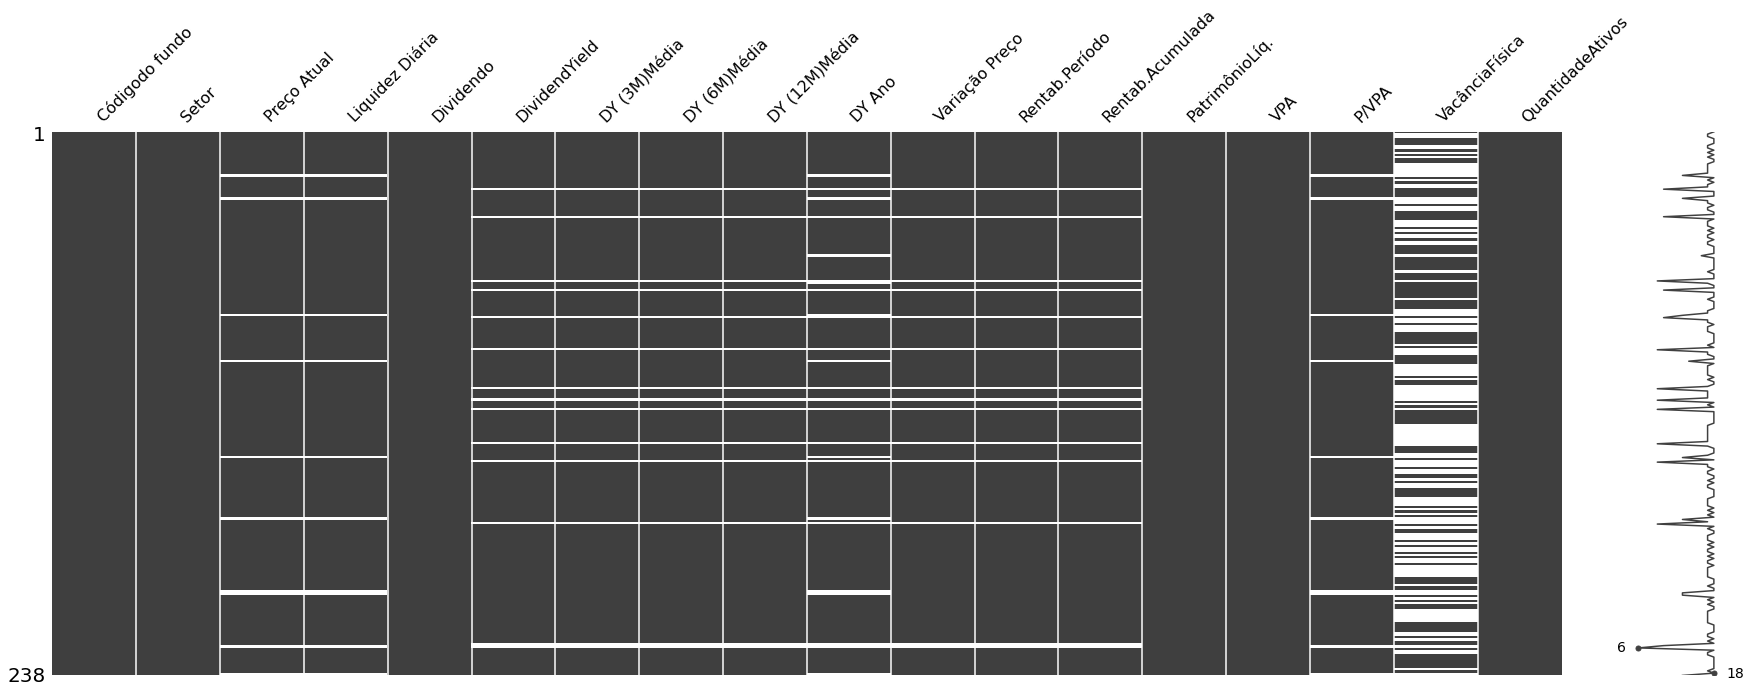

In [6]:
missingno.matrix(df_fiis, figsize = (30,10))

Olhando a contagem e a matriz de dados faltantes, podemos ver que várias linhas possuem muitos dados faltantes, fazendo com que elas não possam ser usadas para a EDA e o modelo, então devemos retirá-las:

In [7]:
df_fiis.dropna(thresh=11, inplace=True)

In [8]:
df_fiis['Setor'].fillna("Residencial",inplace=True)

In [9]:
df_fiis.dropna(subset=["Preço Atual"], inplace=True)

In [10]:
df_fiis.dropna(subset=["DividendYield"], inplace=True)

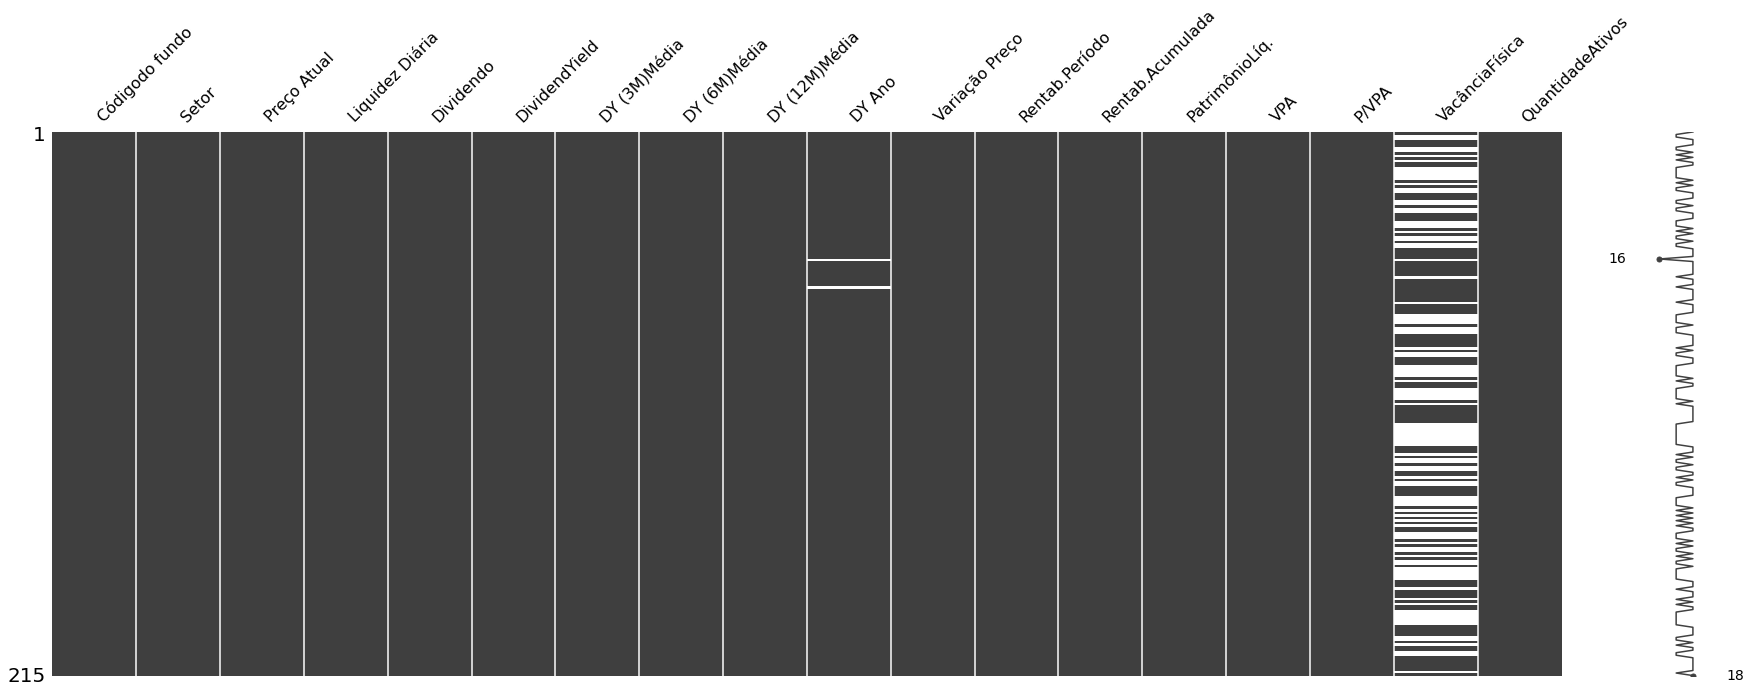

In [11]:
missingno.matrix(df_fiis, figsize = (30,10))

Agora, quase todas as linhas com dados necessários foram retiradas, sobrando apenas duas:

In [12]:
df_fiis[df_fiis['DY Ano'].isnull()]

,Códigodo fundo,Setor,Preço Atual,Liquidez Diária,Dividendo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,DY Ano,Variação Preço,Rentab.Período,Rentab.Acumulada,PatrimônioLíq.,VPA,P/VPA,VacânciaFísica,QuantidadeAtivos
54,ERCR11,Híbrido,85227.76,10.0,1.22,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,2.226739e+08,93717.97,91.0,NaN,0
66,FIVN11,Shoppings,2.97,26598.0,0.00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,6.483287e+07,6.89,43.0,56.0,1


In [13]:
df_fiis['DY Ano'].fillna(0.0,inplace=True)

Olhando para elas, fica claro que seu dividendo no ano foi igual a 0, então preenchemos com esse valor

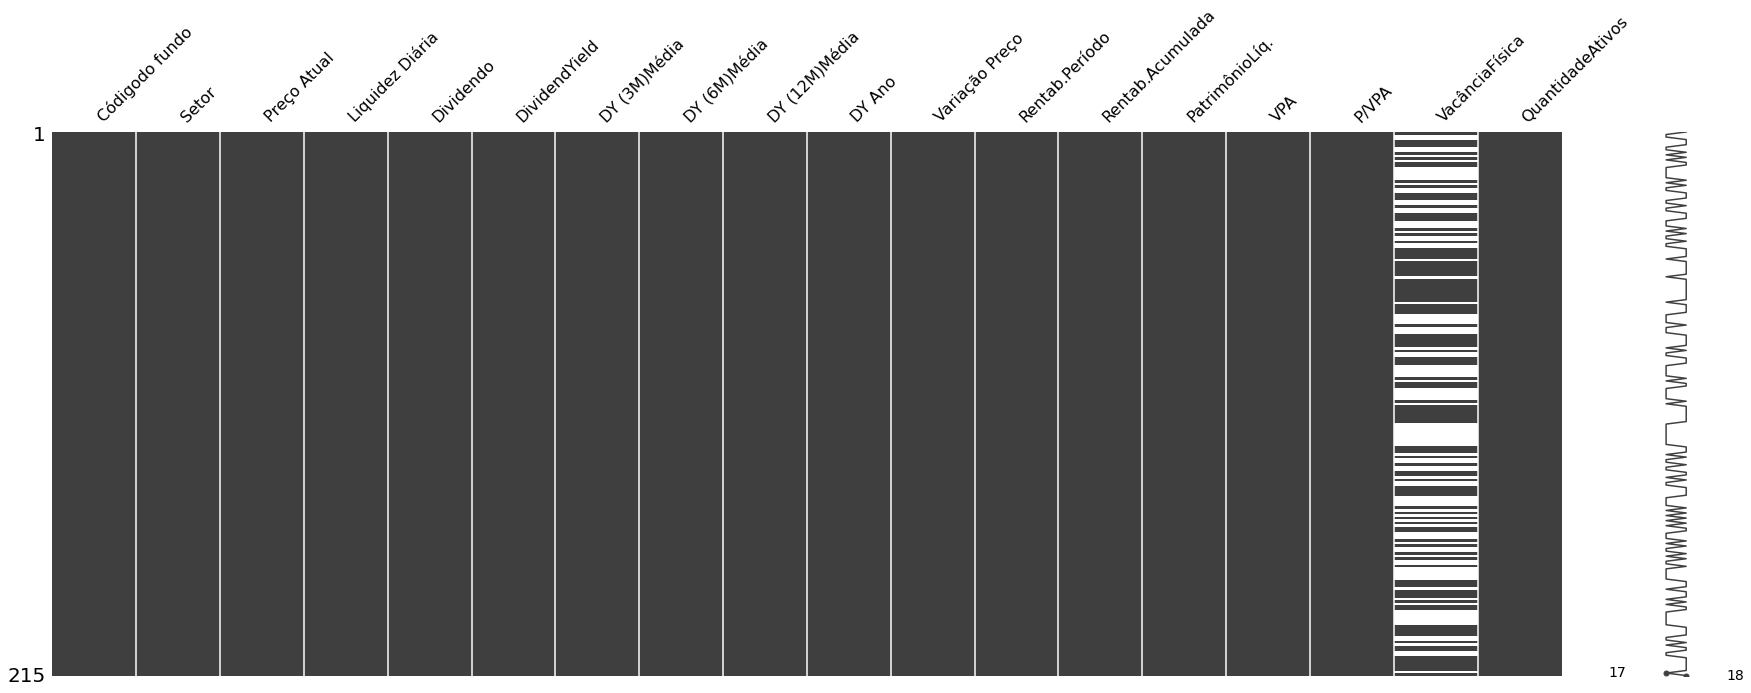

In [14]:
missingno.matrix(df_fiis, figsize = (30,10))

Agora, a única coluna que falta a ter os valores faltantes tratados é a de vacância física, e, pela natureza de muitos fundos, eles simplesmente não possuem esse campo, então, vamos preenchê-lo com a mediana dos valores, para influenciar o menos possível na análise desse campo:

In [15]:
df_fiis.loc[:,"VacânciaFísica"].median()

5.495

In [16]:
filler = 5.4
df_fiis.loc[df_fiis.VacânciaFísica.isnull(), 'VacânciaFísica'] = filler

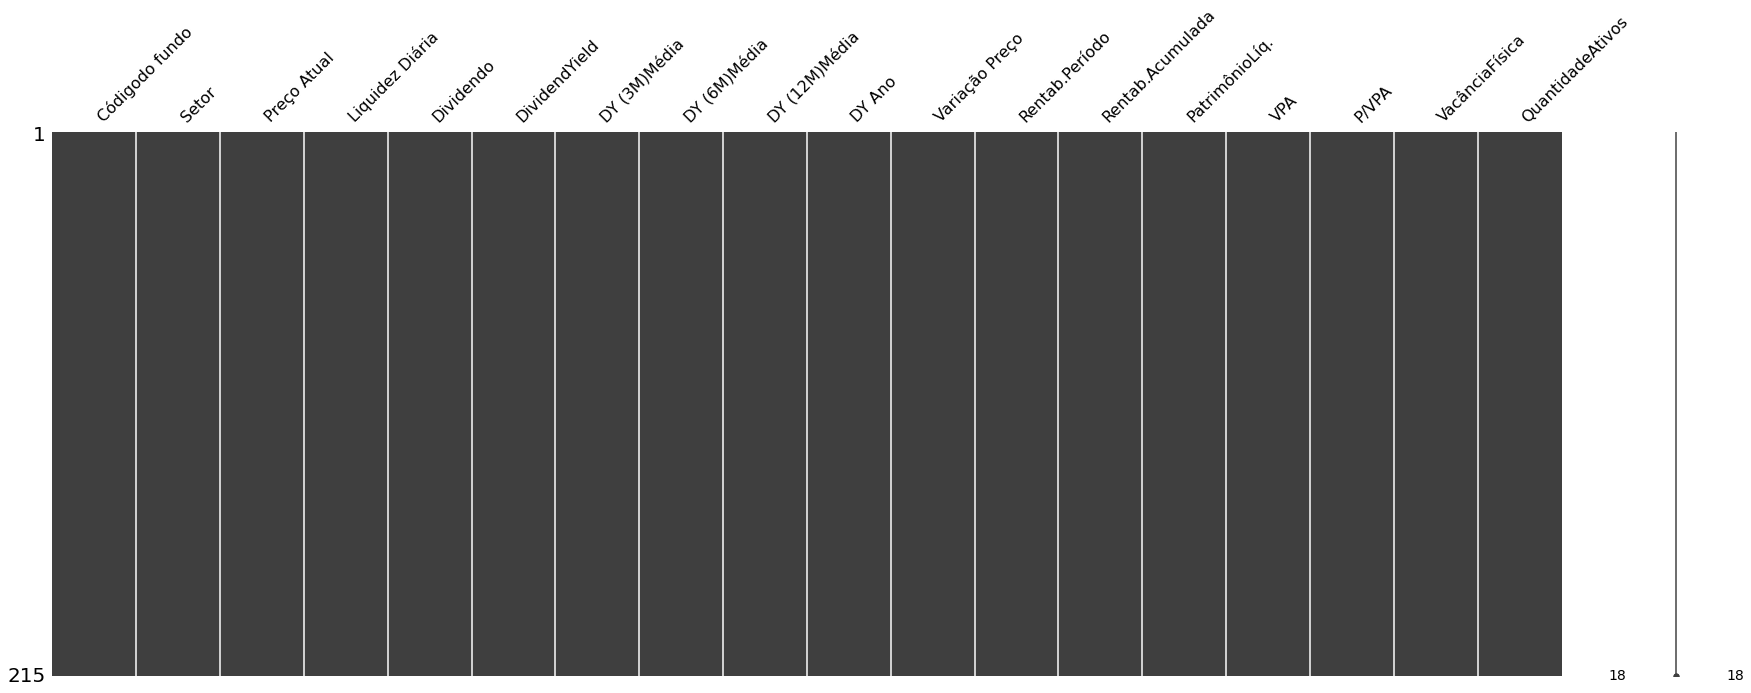

In [17]:
missingno.matrix(df_fiis, figsize = (30,10))

Assim, concluimos o tratamento de valores faltantes.

## Tratamento de Outliers

Agora, vamos tratar os outliers presentes nos dados:

In [18]:
df_fiis.replace([np.inf, -np.inf], np.nan, inplace=True)
df_fiis.dropna(inplace=True)

In [19]:
df_fiis.describe()

,Preço Atual,Liquidez Diária,Dividendo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,DY Ano,Variação Preço,Rentab.Período,Rentab.Acumulada,PatrimônioLíq.,VPA,P/VPA,VacânciaFísica,QuantidadeAtivos
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,2.140000e+02,214.000000,214.000000,214.000000,214.000000
mean,547.158645,21428.827103,1.198738,0.952570,0.693458,0.586262,0.467009,3.104860,-2.615187,-1.717150,-3.615467,5.531636e+08,624.732243,112.476636,10.521916,3.649533
std,5823.438684,74059.629912,3.414182,3.114005,1.101832,0.651536,0.461670,3.660563,9.077002,9.281446,12.193786,7.362897e+08,6409.044722,296.806614,16.967185,8.367362
min,0.750000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-94.650000,-94.620000,-94.590000,-5.941591e+06,-7.830000,-160.000000,0.000000,0.000000
25%,82.977500,429.500000,0.402500,0.482500,0.432500,0.290000,0.000000,1.850000,-3.640000,-3.062500,-6.877500,1.106043e+08,93.910000,84.000000,5.400000,0.000000
50%,98.600000,2749.500000,0.635000,0.630000,0.590000,0.550000,0.510000,2.690000,-1.610000,-0.895000,-1.930000,2.756415e+08,99.650000,97.000000,5.400000,1.000000
75%,111.290000,19828.000000,0.925000,0.797500,0.750000,0.747500,0.667500,3.485000,0.370000,1.090000,2.092500,6.363097e+08,108.002500,103.000000,5.800000,3.000000
max,85227.760000,890062.000000,29.050000,36.320000,12.660000,6.830000,3.770000,39.240000,32.730000,33.030000,33.710000,4.852707e+09,93717.970000,4406.000000,100.000000,72.000000


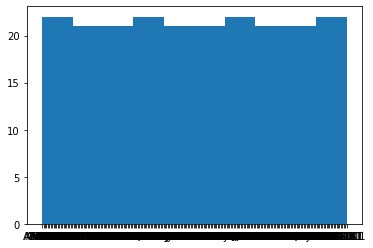

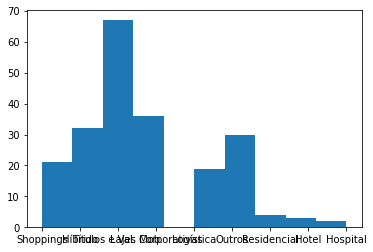

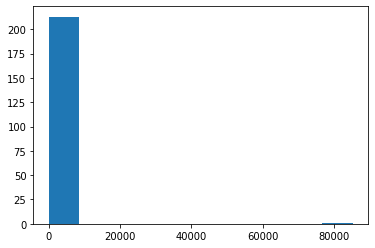

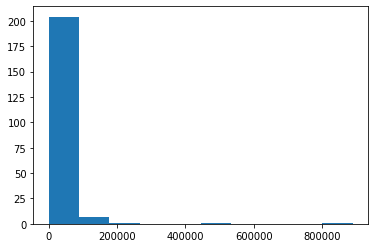

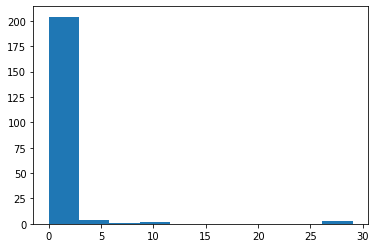

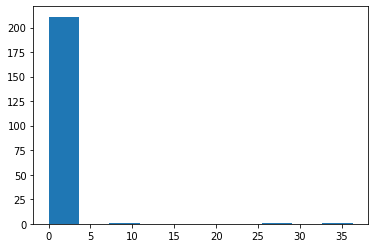

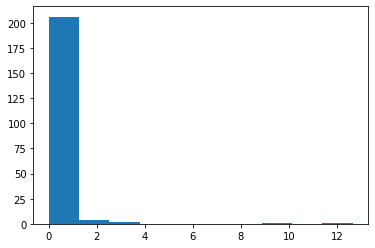

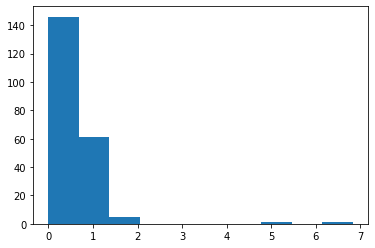

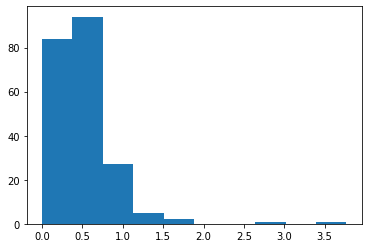

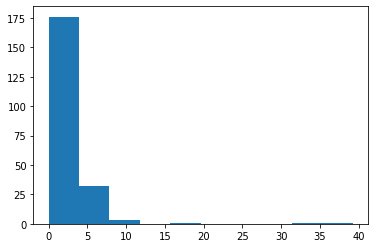

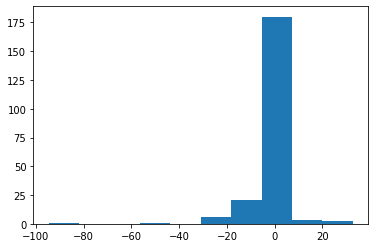

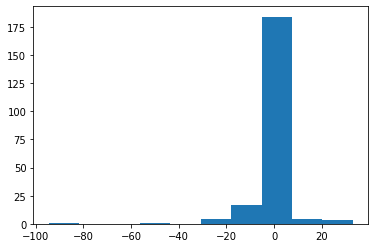

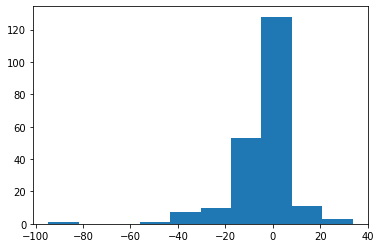

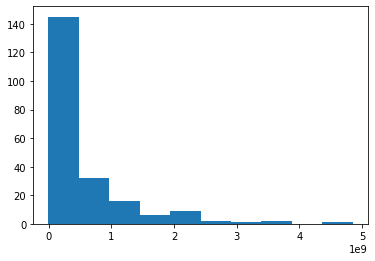

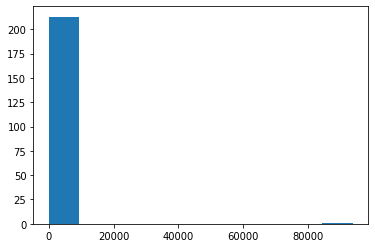

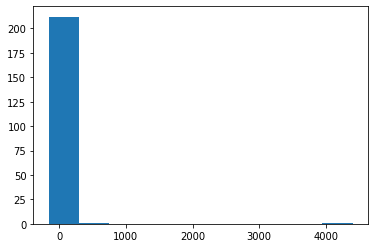

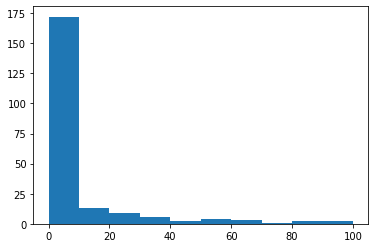

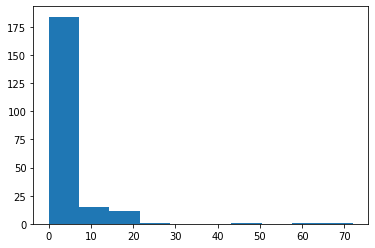

In [20]:
for i in df_fiis.columns:
    plt.figure()
    plt.hist(df_fiis[i])

Olhando a tabela e os gráficos, é possível ver que a maior parte dos campos possui um ou mais outliers, algo que prejudicaria na análise e na criação do modelo de classificação, assim, devemos tratar essas colunas:

In [21]:
columns_to_treat = ['Liquidez Diária', 'Dividendo', 'DividendYield', 'DY (3M)Média', 'DY (6M)Média', 'DY (12M)Média', 'DY Ano', 'Variação Preço', 'Rentab.Período', 'Rentab.Acumulada', 'PatrimônioLíq.', 'VPA', 'P/VPA', 'VacânciaFísica', 'QuantidadeAtivos']

for i in columns_to_treat:
  #Removendo os outliers
  min_threshold, max_threshold = df_fiis[i].quantile([0.001, 0.999])
  df_fiis.drop(df_fiis.loc[df_fiis[i] < min_threshold].index, inplace=True)
  df_fiis.drop(df_fiis.loc[df_fiis[i] > max_threshold].index, inplace=True)

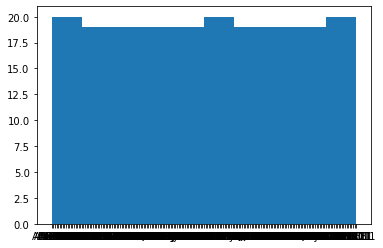

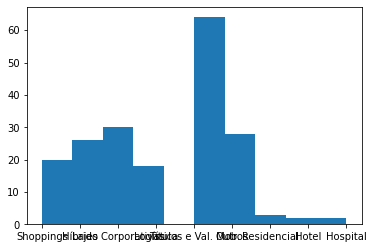

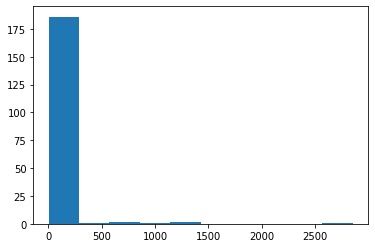

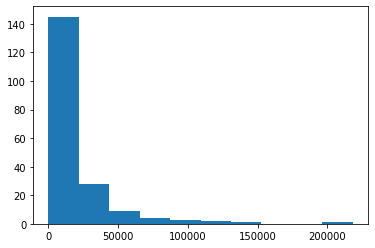

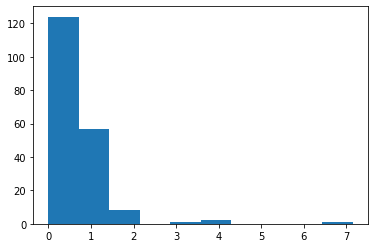

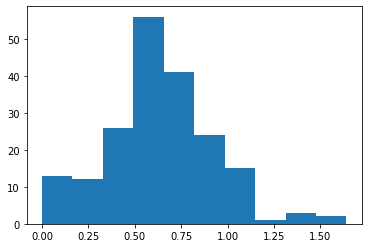

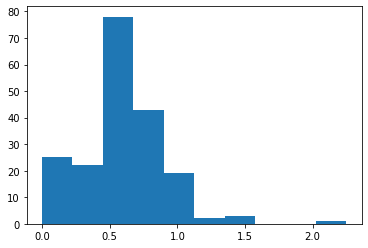

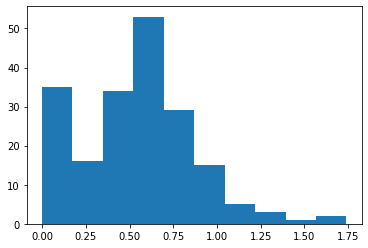

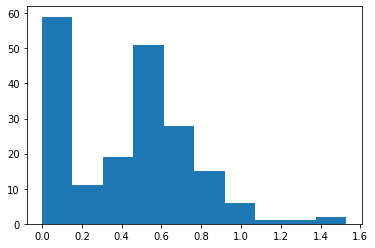

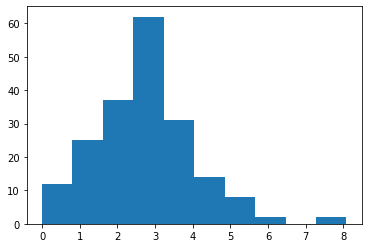

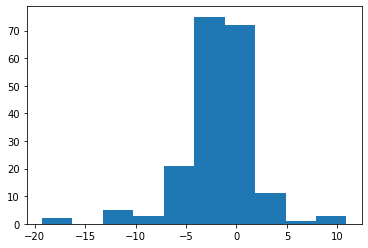

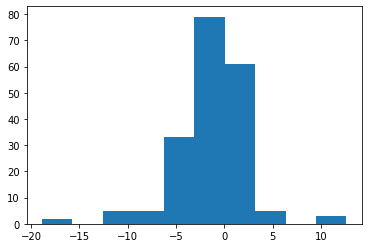

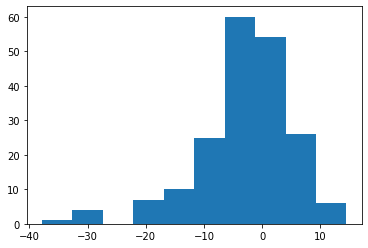

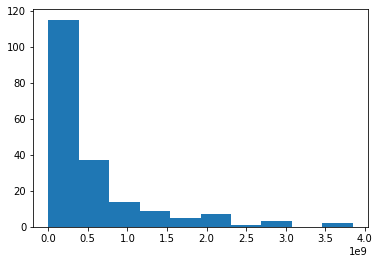

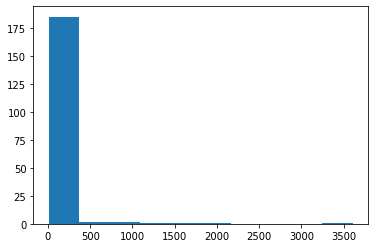

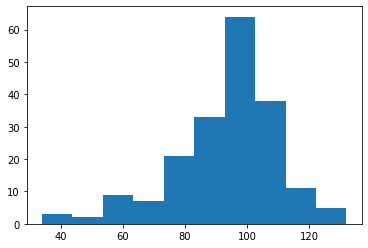

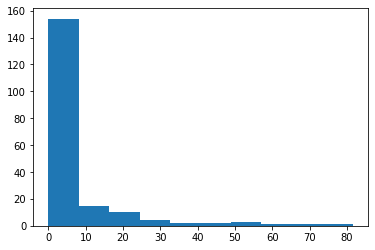

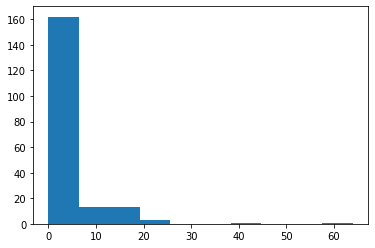

In [22]:
for i in df_fiis.columns:
    plt.figure()
    plt.hist(df_fiis[i])

Agora, como podemos ver, os gráficos estão distribuídos de uma forma bem melhor que antes

## Normalização dos dados

Por último, precisamos fazer a normalização dos dados para o nosso modelo:

In [23]:
# Normalizando os valores nas colunas
columns_to_normalize = ['Liquidez Diária', 'Dividendo', 'DividendYield', 'DY (3M)Média', 'DY (6M)Média', 'DY (12M)Média', 'DY Ano', 'Variação Preço', 'Rentab.Período', 'Rentab.Acumulada', 'PatrimônioLíq.', 'VPA', 'P/VPA', 'VacânciaFísica', 'QuantidadeAtivos']

for i in columns_to_normalize:
  max_value = df_fiis[i].max()
  min_value = df_fiis[i].min()
  df_fiis[i] = (df_fiis[i] - min_value) / (max_value - min_value)

Estado final dos dados:

In [24]:
df_fiis

,Códigodo fundo,Setor,Preço Atual,Liquidez Diária,Dividendo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,DY Ano,Variação Preço,Rentab.Período,Rentab.Acumulada,PatrimônioLíq.,VPA,P/VPA,VacânciaFísica,QuantidadeAtivos
0,ABCP11,Shoppings,70.84,0.004384,0.006993,0.036585,0.191111,0.258621,0.215686,0.160891,0.699139,0.659141,0.759511,0.279613,0.022610,0.469388,0.111520,0.015625
1,AFCR11,Híbrido,110.30,0.007028,0.151049,0.585366,0.417778,0.517241,0.000000,0.561881,0.538436,0.532591,0.759511,0.031292,0.026949,0.734694,0.066176,0.000000
3,AIEC11,Lajes Corporativas,86.27,0.076846,0.079720,0.396341,0.284444,0.356322,0.000000,0.386139,0.529490,0.514467,0.667750,0.124981,0.025911,0.530612,0.000000,0.031250
4,ALMI11,Lajes Corporativas,1160.00,0.000238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.714049,0.671542,0.182374,0.058860,0.570928,0.224490,0.835172,0.015625
5,ALZR11,Logística,128.00,0.053155,0.095105,0.329268,0.217778,0.235632,0.261438,0.230198,0.529821,0.511288,0.684573,0.118626,0.026544,0.928571,0.000000,0.203125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,XPLG11,Logística,114.10,0.258287,0.085315,0.329268,0.231111,0.287356,0.307190,0.311881,0.571571,0.551351,0.648060,0.777037,0.028717,0.704082,0.100490,0.203125
233,XPML11,Shoppings,107.49,0.212628,0.041958,0.176829,0.097778,0.189655,0.189542,0.121287,0.505964,0.480763,0.592430,0.519777,0.028598,0.653061,0.067402,0.203125
234,XPPR11,Outros,62.80,0.148134,0.067133,0.457317,0.320000,0.396552,0.496732,0.425743,0.466865,0.457234,0.382145,0.165145,0.022294,0.387755,0.477941,0.062500
235,XPSF11,Outros,97.50,0.093829,0.121678,0.542683,0.364444,0.454023,0.509804,0.496287,0.657389,0.645469,0.842286,0.109809,0.025350,0.663265,0.066176,0.000000


E agora, transformamos em CSV, para podermos criar o modelo em um outro notebook:

In [25]:
df_csv = df_fiis.to_csv()
print(df_csv)

,Códigodo fundo,Setor,Preço Atual,Liquidez Diária,Dividendo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,DY Ano,Variação Preço,Rentab.Período,Rentab.Acumulada,PatrimônioLíq.,VPA,P/VPA,VacânciaFísica,QuantidadeAtivos
0,ABCP11,Shoppings,70.84,0.004384498027663113,0.006993006993006993,0.036585365853658534,0.19111111111111112,0.25862068965517243,0.21568627450980393,0.1608910891089109,0.6991385023194169,0.659141494435612,0.759510609826037,0.27961328380847983,0.02261005224323919,0.46938775510204084,0.11151960784313726,0.015625
1,AFCR11,Híbrido,110.3,0.007028025051656442,0.15104895104895105,0.5853658536585366,0.41777777777777775,0.5172413793103449,0.0,0.5618811881188119,0.5384360503644798,0.532591414944356,0.759510609826037,0.031291888756807336,0.026948850482181222,0.7346938775510204,0.06617647058823531,0.0
3,AIEC11,Lajes Corporativas,86.27,0.076845543801456,0.07972027972027972,0.39634146341463417,0.28444444444444444,0.3563218390804598,0.0,0.38613861386138615,0.5294897282968853,0.514